# Analyse pour BILL

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt

import utils.stats as stats
import utils.similarity as sim
import utils.plots as plots
from utils.read_vcf import parse_vcf_noerror
from utils.read_ORF import list_interval_with_dico

### Sommaire :
1. Analyse descriptive de P90
    1) Récupération des données depuis vcf
    2) Analyse des fréquences alléliques et profondeurs
    3) Filtrage des sv selon la fréquence et la profondeur
    4) Distribution des types et tailles de sv
    5) Similarité entre échantillons
    6) Variants exclusifs à chaque groupes
    7) Variants exclusifs dans des ORFs

2. Analyse des échantillons au fils des itérations (au fil du temps)
    1) Échantillon 1 (froid)
    2) Échantillon 10 (chaud)

## 1. Analyse descriptive de P90

### 1.1 Récupération des données

- On prend les variants des vcf P90-x avec une liste pour chaque échantillon
- On créé un ensemble avec tous les variants des P90
- On créé un ensemble avec tous les variants du groupe froids : P90-1 à P90-5 
- On créé un ensemble avec tous les variants du groupe chauds : P90-6 à P90-10

In [2]:
data = [parse_vcf_noerror(f'../data/data-p90/P90-{i}.trimed1000.sv_sniffles.vcf') for i in range(1, 11)]

all_variant = sum(data, [])

sample_labels = [f"P90-{i}" for i in range(1, 11)]
cold_labels = sample_labels[:5]
heat_labels = sample_labels[5:]

for v in all_variant:
    if v['svtype'] == "INS":
        print(v["alt"])

GTAAGTACAAATTGTTTGACACATCAACT
AGGCAGGCTGGCCTTTTTTTTGCCACCCACCCACCACCATGGCCACCCACCCACCTTTTTTTTTTTTTTTTTT
TAATGTCTAAGTATTTGTCTAAGTA
GGGCCTGGTGAAAAAAAAAAAAAATAAATAAAAAAAATG
GTAGTGGTGTAGTGGTGTAGTGGTGTAGTGGTGTAGTGGTGTAGTGGTGTAGTGGT
GTAGTGGTGTAGTGGTGTAGTGGTGTAGTGGTGTAGTGGTGTAGTGGTGTAGTGGTGTAGTGGTGTAGTGGT
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTCTC
GGGTAGCCTTGTGGTGGGTAGCCG
TTGTGGTGGGT
CGCGCGCGCGC
TGTGTGTGTGTGTGTGTGTGTGTGTG
TGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTG
TGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTG
TGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTG
CACAGGGACCGTCCACCG
<INS>
CCTCAACCCCGGCAG
CCTCAACCCCGGCAGGAGTCGTCCACGATGGTGACACC
CCTCAACCCCGGCAGGGGGAGTCGTCCACGATGGTGACACC
GCAGCAGTCCCAG
TCCCAGCAGTCCCAGCAGTCCCAGCAG
ACCAGAAGCAGCCGAAGCAGCCGAAGCAGCCGAAGC
<INS>
AGCCGAAGCAGCCGAAGCAGCCGAAGCAGCCGAAGCAGCCGAAGCAGCCGAAGCAGCCGAAGCAGCCGAAGCCACCAAACCCAA
CGAAGCA

### 1.2 Fréquences alléliques et profondeurs dans l'ensemble des variants

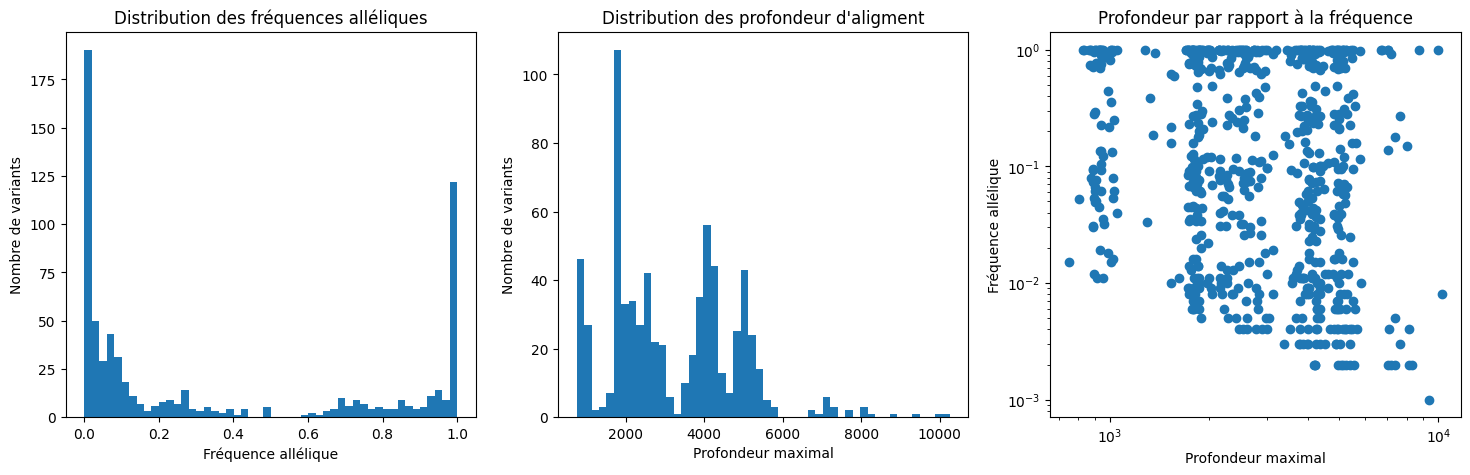

In [42]:
af = [v["af"] for v in all_variant]
depth = [max(v["depth"]) for v in all_variant]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

ax1.hist(af, bins=50)
ax1.set_xlabel('Fréquence allélique')
ax1.set_ylabel('Nombre de variants')
ax1.set_title("Distribution des fréquences alléliques")

ax2.hist(depth, bins=50)
ax2.set_xlabel('Profondeur maximal')
ax2.set_ylabel('Nombre de variants')
ax2.set_title("Distribution des profondeur d'aligment")

ax3.plot(depth, af, 'o')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylabel('Fréquence allélique')
ax3.set_xlabel('Profondeur maximal')
ax3.set_title('Profondeur par rapport à la fréquence')

plt.show()

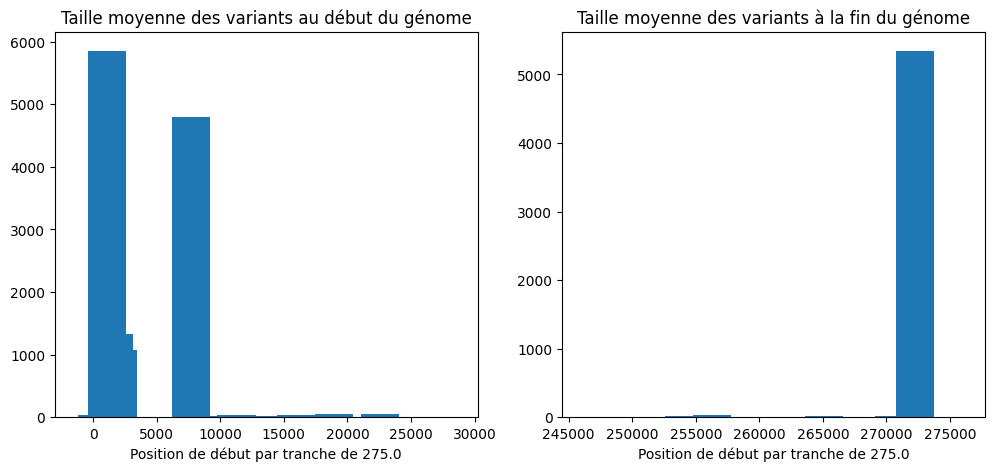

In [4]:
len_by_pos = [(v['pos'], abs(v['svlen'])) for v in all_variant]

size = 275000
steps = 1000
x = [(size / steps) * i for i in range(0, steps)]
y = [[] for i in range(0, steps)]
for l in len_by_pos:
    step = int(l[0] / (size / steps))
    y[step].append(l[1])
y = [np.mean(y[i]) if len(y[i]) > 0 else 0 for i in range(len(y))]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax1, ax2 = axes
ax1.bar(x[0:int(0.1*steps)], y[0:int(0.1*steps)], width=3000)
ax1.set_xlabel(f'Position de début par tranche de {size / steps}')
ax1.set_title("Taille moyenne des variants au début du génome")
ax2.bar(x[int(0.9*steps):steps], y[int(0.9*steps):steps], width=3000)
ax2.set_xlabel(f'Position de début par tranche de {size / steps}')
ax2.set_title("Taille moyenne des variants à la fin du génome")
plt.show()

### 1.3 Filtrage des variants basés sur une profondeur, une fréquence allélique minimum et une taille maximum

- Pour la profondeur on considère la valeur max des différentes profondeurs fournis pour un même variant

In [5]:
min_depth = 500
min_freq = 0.2
data = [[v for v in d if v['af'] > min_freq and max(v['depth'])> min_depth] for d in data]
data = [[v for v in d if (10000 < v['pos'] < 270000) or v['svlen'] < 2000] for d in data]

### 1.4 Distribution des type et des tailles de variants

- Les variants sont regroupé par similarité (\<thresold\> = proportion minimum de similarité), ceci pour l'ensemble total, l'ensemble chaud et l'ensemble froid
- La similarité entre 2 variants structurels est calculé d'après le nombre de base partagés (identiques à la même position) entre les 2
- Ainsi plusieurs occurences "similaires" d'un même variant ne sont compté qu'une fois

#### 1.4.1 Distribution des types

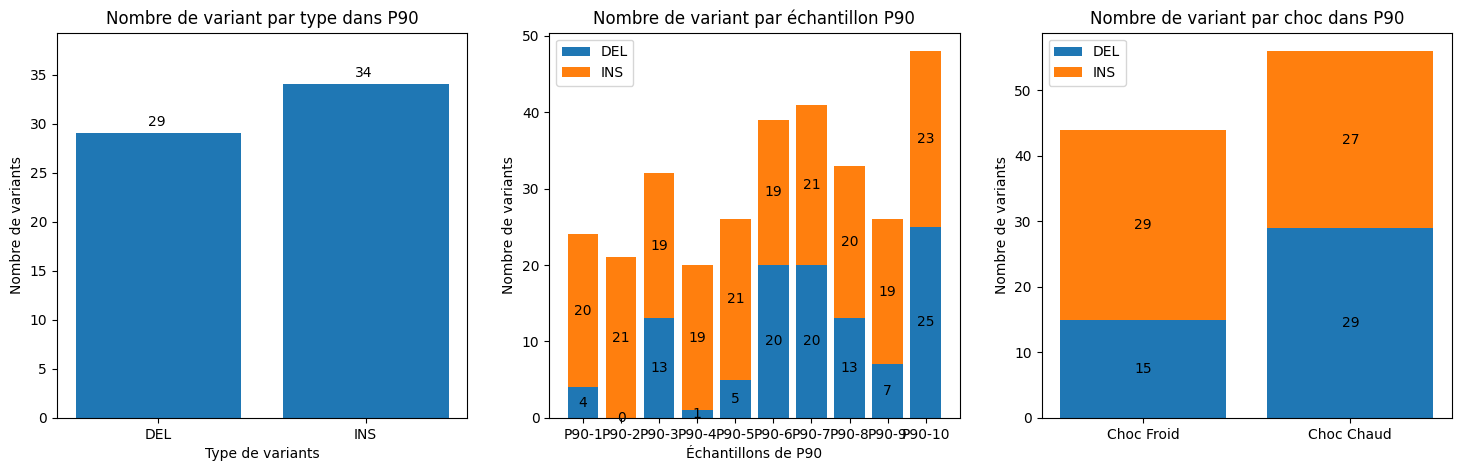

In [6]:
thresold = 1

grouped_by_sample = sim.merge_samples(data, sample_labels, sim_thresold=thresold)

types_counts = stats.count_types([grp[0][1]["svtype"] for grp in grouped_by_sample])
types_by_sample = stats.count_types_by_group(grouped_by_sample, sample_labels)
types_by_choc = stats.count_types_by_group(grouped_by_sample, [cold_labels, heat_labels])

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

plots.barplot(types_counts, ax1)
ax1.set_ylabel('Nombre de variants')
ax1.set_xlabel('Type de variants')
ax1.set_title('Nombre de variant par type dans P90')

plots.grouped_barplot(types_by_sample, sample_labels, ax2)
ax2.set_ylabel('Nombre de variants')
ax2.set_xlabel('Échantillons de P90')
ax2.set_title('Nombre de variant par échantillon P90')

plots.grouped_barplot(types_by_choc, ["Choc Froid", "Choc Chaud"], ax3)
ax3.set_ylabel('Nombre de variants')
ax3.set_title('Nombre de variant par choc dans P90')
plt.show()

#### 1.4.2 Distribution de tailles par type, avec et sans outliers

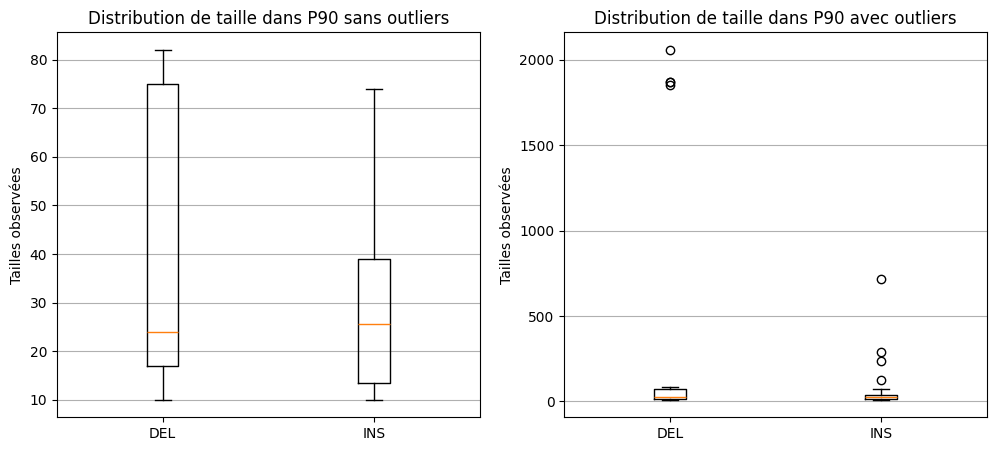

In [7]:
len_distrib_all = stats.len_by_type([(grp[0][1]["svtype"], np.mean([x[1]["svlen"] for x in grp])) for grp in grouped_by_sample])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plots.boxplot(len_distrib_all, False, ax1)
ax1.set_ylabel('Tailles observées')
ax1.set_title("Distribution de taille dans P90 sans outliers")

plots.boxplot(len_distrib_all, True, ax2)
ax2.set_ylabel('Tailles observées')
ax2.set_title("Distribution de taille dans P90 avec outliers")

plt.show()


### 1.5 Similarité par paire d'échantillon P90

- La case P90-4 / P90-5 par exemple affiche la proportion de variants partagé (similaires) entre ces deux échantillons

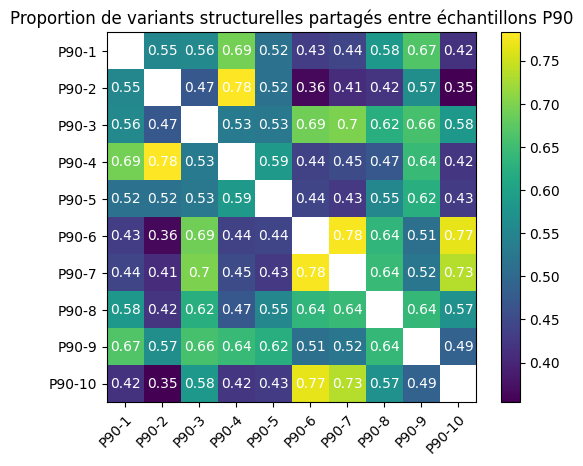

In [8]:
sims = stats.pairwise_similarity(grouped_by_sample, sample_labels)

fig, ax = plt.subplots()
plots.heatmap(sims, sample_labels, ax)
ax.set_title("Proportion de variants structurelles partagés entre échantillons P90")
plt.show()

### 1.6 Extraction des variants présent uniquement dans le chaud ou le froid

- On compte aussi le nombre d'occurence de chaque variant au travers des échantillons

In [9]:
only_cold = []
only_heat = []

for g in grouped_by_sample:
    present_in = 0
    counts = len(g)
    for v in g:
        if v[0] in cold_labels:
            present_in = present_in | 1
        elif v[0] in heat_labels:
            present_in = present_in | 2
        else:
            raise ValueError("Unexpected label")
    
    if present_in == 1:
        g[0][1]["n_found"] = counts
        g[0][1]["samples_found"] = [v[0] for v in g]
        only_cold.append(g[0][1])

    elif present_in == 2:
        g[0][1]["n_found"] = counts
        g[0][1]["samples_found"] = [v[0] for v in g]
        only_heat.append(g[0][1])

#### Variants trouvés uniquement dans le groupe froid

In [10]:
for c in only_cold:
    print(c)

{'pos': 37879, 'id': 'Sniffles2.INS.70S0', 'svtype': 'INS', 'svlen': 26, 'end': 37879, 'af': 0.671, 'depth': [4318.0, 4144.0, 4172.0, 4157.0, 4353.0], 'alt': 'TGTGTGTGTGTGTGTGTGTGTGTGTG', 'n_found': 1, 'samples_found': ['P90-1']}
{'pos': 83076, 'id': 'Sniffles2.INS.EDS0', 'svtype': 'INS', 'svlen': 48, 'end': 83076, 'af': 0.746, 'depth': [3694.0, 3725.0, 3687.0, 3639.0, 3637.0], 'alt': 'CGAAGCAGCCGAAGCAGCCGAAGCAGCCGAAGCAGACCAAACCCGACG', 'n_found': 1, 'samples_found': ['P90-5']}
{'pos': 270829, 'id': 'Sniffles2.INS.33BS0', 'svtype': 'INS', 'svlen': 19, 'end': 270829, 'af': 0.8, 'depth': [4962.0, 4868.0, 5040.0, 5113.0, 5105.0], 'alt': 'ACAGAGACACAAAACAGAC', 'n_found': 1, 'samples_found': ['P90-2']}
{'pos': 272444, 'id': 'Sniffles2.INS.34CS0', 'svtype': 'INS', 'svlen': 715, 'end': 272444, 'af': 1.0, 'depth': [5130.0, 1.0, 1.0, 1.0, 0.0], 'alt': 'TTGAACATGGTGGACACGGTGGAAGGTTGAACATGGTGGACACGGTGGAAGGTTGAACATGGTGGACACGGTGGAAGGTTGAACATGGTGGACACGGTGGAAGGTTGAACATGGTGGACACGGTGGAAGGTTGAACATGGTGGAC

#### Variants trouvés uniquement dans le groupe chaud

In [11]:
for h in only_heat:
    print(h)

{'pos': 9457, 'id': 'Sniffles2.DEL.1D5S0', 'svtype': 'DEL', 'svlen': -17, 'end': 9474, 'af': 0.594, 'depth': [1572.0, 1551.0, 1499.0, 1489.0, 1399.0], 'n_found': 1, 'samples_found': ['P90-10']}
{'pos': 11384, 'id': 'Sniffles2.DEL.26BS0', 'svtype': 'DEL', 'svlen': -33, 'end': 11417, 'af': 1.0, 'depth': [3304.0, 3337.0, 3329.0, 3400.0, 3455.0], 'n_found': 5, 'samples_found': ['P90-6', 'P90-7', 'P90-8', 'P90-9', 'P90-10']}
{'pos': 15501, 'id': 'Sniffles2.INS.35S0', 'svtype': 'INS', 'svlen': 12, 'end': 15501, 'af': 1.0, 'depth': [6742.0, 6831.0, 6910.0, 6939.0, 7022.0], 'alt': 'TCATCATCATCA', 'n_found': 1, 'samples_found': ['P90-9']}
{'pos': 16096, 'id': 'Sniffles2.DEL.1E5S0', 'svtype': 'DEL', 'svlen': -12, 'end': 16108, 'af': 0.616, 'depth': [1356.0, 1431.0, 1473.0, 1482.0, 1536.0], 'n_found': 1, 'samples_found': ['P90-10']}
{'pos': 16098, 'id': 'Sniffles2.DEL.1E6S0', 'svtype': 'DEL', 'svlen': -20, 'end': 16118, 'af': 0.216, 'depth': [1356.0, 1431.0, 1473.0, 1482.0, 1536.0], 'n_found': 1,

### 1.7 Variants exclusifs à chaque groupes, se trouvant dans une ORF

In [12]:
orfs = list_interval_with_dico("../ORF.fasta")

print("Froids dans les ORFs : ")
for c in only_cold:
    for orf in orfs:
        found = False
        for inter in orf["location"]:
            found = found or (min(c["end"], int(inter[1])) - max(c["pos"], int(inter[0])) > 0)
        if found:
            print(" ORF : ", orf)
            print(" Mutation : ", c)
            print()

print("Chauds dans les ORFs : ")
for h in only_heat:
    for orf in orfs:
        found = False
        for inter in orf["location"]:
            found = found or (min(h["end"], int(inter[1])) - max(h["pos"], int(inter[0])) > 0)
        if found:
            print(" ORF : ", orf)
            print(" Mutation : ", h)
            print()

Froids dans les ORFs : 
Chauds dans les ORFs : 
 ORF :  {'locus_tag': 'CyHV3_ORF5_1', 'protein_id': 'YP_001096044.1', 'location': [['8606', '9949']], 'direct': True, 'complement': False, 'join': False}
 Mutation :  {'pos': 9457, 'id': 'Sniffles2.DEL.1D5S0', 'svtype': 'DEL', 'svlen': -17, 'end': 9474, 'af': 0.594, 'depth': [1572.0, 1551.0, 1499.0, 1489.0, 1399.0], 'n_found': 1, 'samples_found': ['P90-10']}

 ORF :  {'locus_tag': 'CyHV3_ORF25', 'protein_id': 'YP_001096064.1', 'location': [['45570', '47375']], 'direct': True, 'complement': False, 'join': False}
 Mutation :  {'pos': 47346, 'id': 'Sniffles2.DEL.2D2S0', 'svtype': 'DEL', 'svlen': -1850, 'end': 49196, 'af': 0.49, 'depth': [2047.0, 2004.0, 1989.0, 2004.0, 2034.0], 'n_found': 1, 'samples_found': ['P90-7']}

 ORF :  {'locus_tag': 'CyHV3_ORF26', 'protein_id': 'YP_005352783.1', 'location': [['47474', '47644']], 'direct': True, 'complement': False, 'join': False}
 Mutation :  {'pos': 47346, 'id': 'Sniffles2.DEL.2D2S0', 'svtype': 'DE

## 2. Comparaison entre les itération d'un même échantillon (au fil du temps)

### 2.1 Analyse de l'échantillon 1 (froid)

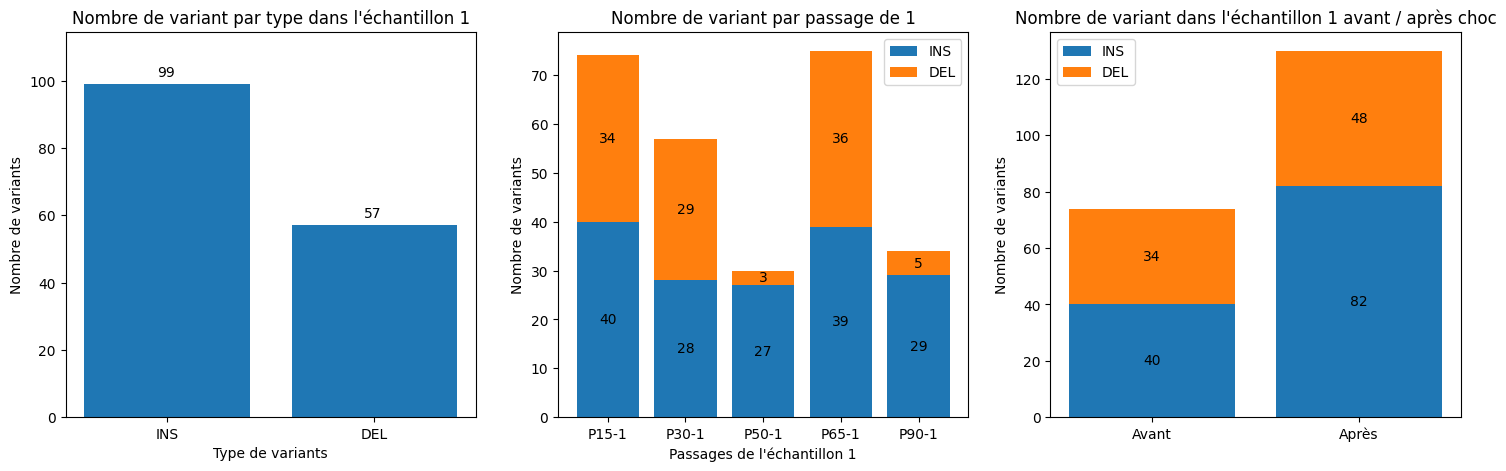

In [13]:
min_depth_it = 150
min_freq_it = 0.05
thresold = 1

iterations = ["15", "30", "50", "65", "90"]
it_labels = [f"P{it}-1" for it in iterations]

data_it = [parse_vcf_noerror(f'../data/data-p{i}/P{i}-1.trimed1000.sv_sniffles.vcf') for i in iterations]
data_it = [[v for v in d if v['af'] > min_freq_it and max(v['depth']) > min_depth_it] for d in data_it]

grouped_by_it = sim.merge_samples(data_it, it_labels, sim_thresold=thresold)

types_counts = stats.count_types([grp[0][1]["svtype"] for grp in grouped_by_it])
types_by_it = stats.count_types_by_group(grouped_by_it, it_labels)
types_by_period = stats.count_types_by_group(grouped_by_it, [it_labels[:1], it_labels[1:]])

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

plots.barplot(types_counts, ax1)
ax1.set_ylabel('Nombre de variants')
ax1.set_xlabel('Type de variants')
ax1.set_title('Nombre de variant par type dans l\'échantillon 1')

plots.grouped_barplot(types_by_it, it_labels, ax2)
ax2.set_ylabel('Nombre de variants')
ax2.set_xlabel('Passages de l\'échantillon 1')
ax2.set_title('Nombre de variant par passage de 1')

plots.grouped_barplot(types_by_period, ["Avant", "Après"], ax3)
ax3.set_ylabel('Nombre de variants')
ax3.set_title('Nombre de variant dans l\'échantillon 1 avant / après choc')
plt.show()

Text(0.5, 1.0, 'Proportion de variants structurelles partagés entre passage')

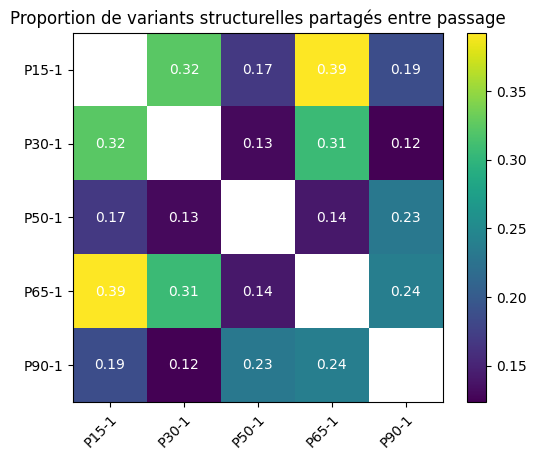

In [14]:
sims_it = stats.pairwise_similarity(grouped_by_it, it_labels)

fig, ax = plt.subplots()
plots.heatmap(sims_it, it_labels, ax)
ax.set_title("Proportion de variants structurelles partagés entre passage")

### 2.1 Analyse de l'échantillon 10 (chaud)

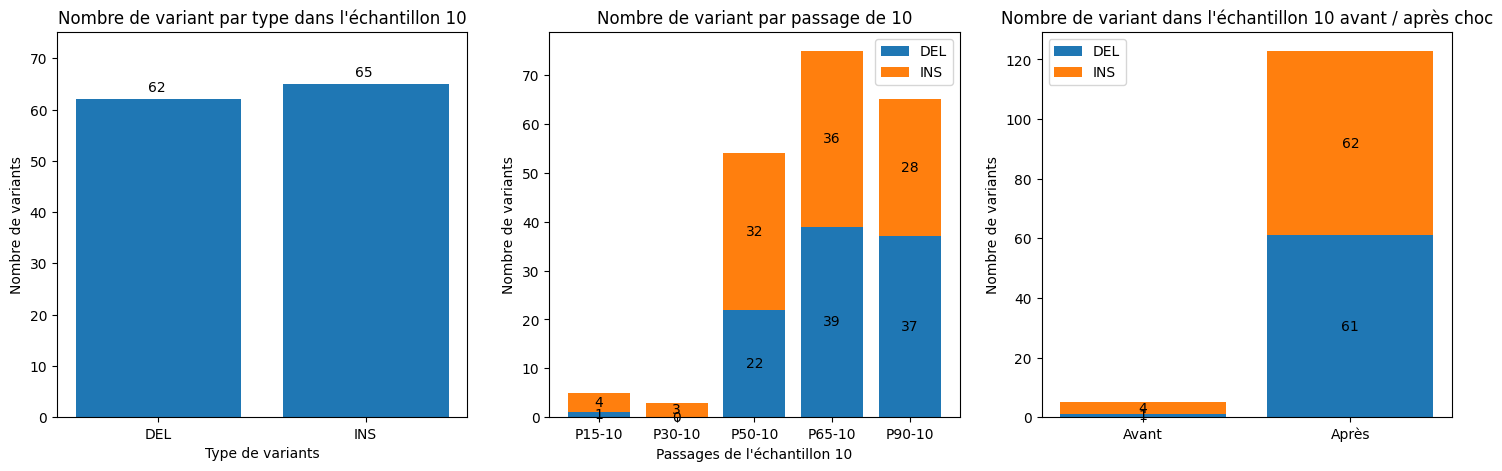

In [15]:
min_depth_it = 150
min_freq_it = 0.05
thresold = 1

iterations = ["15", "30", "50", "65", "90"]
it_labels = [f"P{it}-10" for it in iterations]

data_it = [parse_vcf_noerror(f'../data/data-p{i}/P{i}-10.trimed1000.sv_sniffles.vcf') for i in iterations]
data_it = [[v for v in d if v['af'] > min_freq_it and max(v['depth']) > min_depth_it] for d in data_it]

grouped_by_it = sim.merge_samples(data_it, it_labels, sim_thresold=thresold)

types_counts = stats.count_types([grp[0][1]["svtype"] for grp in grouped_by_it])
types_by_it = stats.count_types_by_group(grouped_by_it, it_labels)
types_by_period = stats.count_types_by_group(grouped_by_it, [it_labels[:1], it_labels[1:]])

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

plots.barplot(types_counts, ax1)
ax1.set_ylabel('Nombre de variants')
ax1.set_xlabel('Type de variants')
ax1.set_title('Nombre de variant par type dans l\'échantillon 10')

plots.grouped_barplot(types_by_it, it_labels, ax2)
ax2.set_ylabel('Nombre de variants')
ax2.set_xlabel('Passages de l\'échantillon 10')
ax2.set_title('Nombre de variant par passage de 10')

plots.grouped_barplot(types_by_period, ["Avant", "Après"], ax3)
ax3.set_ylabel('Nombre de variants')
ax3.set_title('Nombre de variant dans l\'échantillon 10 avant / après choc')

plt.show()

Text(0.5, 1.0, 'Proportion de variants structurelles partagés entre passage')

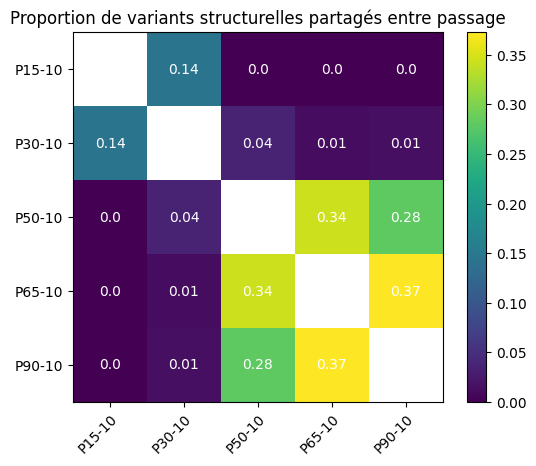

In [16]:
sims_it = stats.pairwise_similarity(grouped_by_it, it_labels)

fig, ax = plt.subplots()
plots.heatmap(sims_it, it_labels, ax)
ax.set_title("Proportion de variants structurelles partagés entre passage")